# Getting started with timm library

`timm` is a deep-learning library created by Ross Wightman and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results.

Now let's see how to make use the pretrained models with fastai and train a classifier. 

## Installation

We can install the `timm` library from pip: 

`pip install timm`

Or we can directly install it from github source for more updated version:

`pip install git+https://github.com/rwightman/pytorch-image-models.git`

Now let's get started and see how to load the model from timm and use it with fastai

In [1]:
!pip install timm -q

## Getting Started

Now let's import the necessary libraries,

In [2]:
from fastai.vision.all import *

import timm

Now let's download the `PETS` dataset, 

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path = (path/'images')

In [5]:
path.ls()

(#7393) [Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/german_shorthaired_97.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/Bombay_157.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/Bengal_12.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/japanese_chin_116.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/havanese_109.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/scottish_terrier_122.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_146.jpg'),Path('/home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/boxer_176.jpg')...]

Before creating the datablock let's see some info about the dataset i.e. the Pets dataset has almost 7.4k images of 37 breeds of cats and dogs. But now let's just train a cat vs dog classifier. 

## Create Datablock and Dataloaders

First let's see some images and create the dataloaders

Path:  /home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg


<AxesSubplot:>

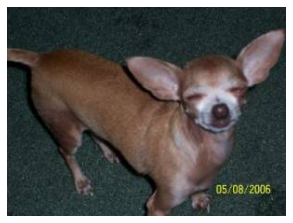

In [6]:
print("Path: ", path.ls()[1])
img = PILImage.create(path.ls()[1])
img.show()

Path:  /home/studio-lab-user/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg


<AxesSubplot:>

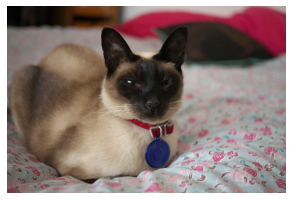

In [7]:
print("Path: ", path.ls()[0])
img = PILImage.create(path.ls()[0])
img.show()

We can see that all the names of dog images in this datasset start with a lowercase letter and names of cat images start with uppercase letter.

In [8]:
def get_label(x):
    if x.name[0].isupper():
        return 'Cat'
    else:
        return 'Dog'

By using the above function, we can now label every image

Now create the datablock,

In [9]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=get_label,
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(420),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.5),
                Normalize.from_stats(*imagenet_stats)]
)

In [10]:
dls = pets.dataloaders(path, bs=32)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


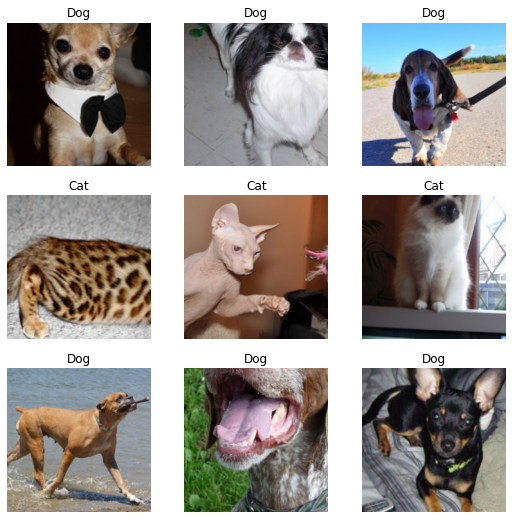

In [11]:
dls.show_batch()

## Using Timm library

The `Timm` library consists of different state-of-the-art models with pretrained wights. Now let's see how to use them.

We can get the list of the models by using : `timm.list_models()`

In [12]:
timm.list_models()[:10]

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384']

In [13]:
print("Number of available model: ",len(timm.list_models()))

Number of available model:  612


That's golden.. There are 612 pretrained models

Now let' create a model using `create_model()` method.

In [20]:
model = timm.create_model('efficientnet_b3a', pretrained=True, num_classes=1).cuda()

In the above line we have created an `efficientnet_b3a` model with pretrained weights and have replaced the head with the number of output nodes in our dataset i.e 1. (Since it is binary classification)

Let's check the dimensions of the inputs, targets and model activations. 

In [15]:
x,y = dls.one_batch()

In [16]:
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [17]:
dls.vocab

['Cat', 'Dog']

## Model training 

Now let's create the `Learner` object with dataloader and model. 

In [21]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=accuracy)

Now let's find the learning rate and train the model

SuggestedLRs(valley=9.120108734350652e-05)

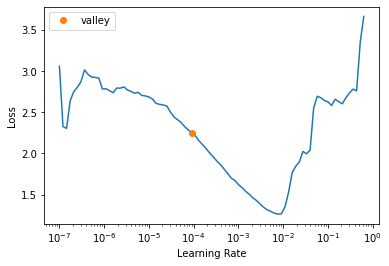

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(5, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.332003,0.101814,0.322057,01:28
1,0.103348,0.039152,0.322057,01:28
2,0.068146,0.575195,0.322057,01:28


KeyboardInterrupt: 

Woah... Our model has done a good job and was able to achive 99% accuracy on the pets dataset. 

## Inference

Now let's get some predictions from the validation dataset

In [ ]:
interep = ClassificationInterpretation.from_learner(learn)

In [ ]:
interep.print_classification_report()